### Outline of the model 

- Start by importing the libraries, 
- Then the model, and have a look at it
- Then we filter out some columns unnecessary to our model
- Filter out the period of Covid19
- Integrate the French holidays in the dataframe


In [343]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

In [344]:
data = pd.read_csv("final_data/data_attendance_weather.csv")

data.head()

,date,temp,humidity,wind_speed,rain_1h,snow_1h,clouds_all,attendance
0,2018-06-01,17.887500,89.916667,2.472917,5.17,0.0,2379,46804.0
1,2018-06-02,19.352500,77.541667,1.468750,0.00,0.0,1019,57940.0
2,2018-06-03,20.275833,72.666667,2.939167,0.00,0.0,1411,44365.0
3,2018-06-04,20.721667,74.791667,2.471250,0.15,0.0,2137,37617.0
4,2018-06-05,18.089583,84.791667,3.377917,3.86,0.0,2367,32438.0


### We delete COVID-19 period to filter out from the dataframe

In [345]:
# Define the COVID-19 period to filter out
start_date = "2020-07-01"
end_date = "2021-06-30"

# Remove rows within the specified COVID-19 period
data = data[(data["date"] < start_date) | (data["date"] > end_date)]

### Test of the impact of French holidays on attendance

In [346]:
!pip install vacances-scolaires-france
!pip install holidays

In [347]:
import pandas as pd
import numpy as np
import holidays
from vacances_scolaires_france import SchoolHolidayDates

def clean_and_encode_data(file_path, zone="C"):
    """
    Loads a CSV file, cleans, and formats the data by adding public holidays, 
    school holidays, attendance correction, cyclical encoding of weekdays/months, 
    and removes the COVID-19 period.

    Args:
    - file_path (str): Path to the CSV file.
    - zone (str): School holiday zone (default is "C" for France).

    Returns:
    - pd.DataFrame: Cleaned and formatted DataFrame.
    """

    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'date' column is in datetime format
    data["date"] = pd.to_datetime(data["date"])

    # ---- Remove COVID-19 Period ----
    start_date = "2020-07-01"
    end_date = "2021-06-30"
    data = data[(data["date"] < start_date) | (data["date"] > end_date)]

    # ---- Add Public Holidays ----
    fr_holidays = holidays.France(years=data["date"].dt.year.unique())
    data["Is_Bank_Holiday"] = data["date"].apply(lambda x: 1 if x in fr_holidays else 0)

    # ---- Add School Holidays ----
    d = SchoolHolidayDates()
    def is_school_holiday(date, zone=zone):
        return d.is_holiday_for_zone(date, zone)
    
    data["Is_School_Holiday"] = data["date"].apply(lambda x: 1 if is_school_holiday(x.date(), zone) else 0)

    # Merge public and school holidays into one column
    data["Is_Holiday"] = data[["Is_Bank_Holiday", "Is_School_Holiday"]].max(axis=1)
    data.drop(columns=["Is_Bank_Holiday", "Is_School_Holiday"], inplace=True)

    # ---- Clean Attendance Values ----
    data["attendance"] = data["attendance"].apply(lambda x: max(0, x))

    # ---- Add Day of the Week ----
    data["day_of_week"] = data["date"].dt.day_name()

    # ---- Extract and Encode Month ----
    data["month"] = data["date"].dt.month
    data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
    data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

    # ---- Encode Day of the Week ----
    day_mapping = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
                   "Friday": 4, "Saturday": 5, "Sunday": 6}
    
    data["day_of_week_int"] = data["day_of_week"].map(day_mapping)
    data["day_of_week_sin"] = np.sin(2 * np.pi * data["day_of_week_int"] / 7)
    data["day_of_week_cos"] = np.cos(2 * np.pi * data["day_of_week_int"] / 7)
    data.drop(columns=["day_of_week_int"], inplace=True)

    return data


In [348]:
import pandas as pd
import holidays
from vacances_scolaires_france import SchoolHolidayDates

def add_is_holiday(data, zone="C"):
    """
    Adds a column 'Is_Holiday' to the dataset based on public holidays and school holidays.

    Args:
    - data (pd.DataFrame): DataFrame containing a 'date' column.
    - zone (str): School holiday zone (default is "C" for France).

    Returns:
    - pd.DataFrame: DataFrame with the 'Is_Holiday' column added.
    """
    
    # Ensure 'date' column is in datetime format
    data["date"] = pd.to_datetime(data["date"])

    # Add public holidays
    fr_holidays = holidays.France(years=data["date"].dt.year.unique())
    data["Is_Bank_Holiday"] = data["date"].apply(lambda x: 1 if x in fr_holidays else 0)

    # Add school holidays
    d = SchoolHolidayDates()
    def is_school_holiday(date, zone=zone):
        return d.is_holiday_for_zone(date, zone)
    
    data["Is_School_Holiday"] = data["date"].apply(lambda x: 1 if is_school_holiday(x.date(), zone) else 0)

    # Merge into a single 'Is_Holiday' variable
    data["Is_Holiday"] = data[["Is_Bank_Holiday", "Is_School_Holiday"]].max(axis=1)

    # Drop intermediate columns
    data.drop(columns=["Is_Bank_Holiday", "Is_School_Holiday"], inplace=True)

    return data


In [349]:
import numpy as np

def clean_and_encode_data(data):
    """
    Cleans and encodes the dataset after 'Is_Holiday' has been added.

    Args:
    - data (pd.DataFrame): DataFrame with at least a 'date' column.

    Returns:
    - pd.DataFrame: Cleaned and encoded DataFrame.
    """

    # ---- Remove COVID-19 Period ----
    start_date = "2020-07-01"
    end_date = "2021-06-30"
    data = data[(data["date"] < start_date) | (data["date"] > end_date)]

    # ---- Clean Attendance Values ----
    data["attendance"] = data["attendance"].apply(lambda x: max(0, x))

    # ---- Add Day of the Week ----
    data["day_of_week"] = data["date"].dt.day_name()

    # ---- Extract and Encode Month ----
    data["month"] = data["date"].dt.month
    data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
    data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

    # ---- Encode Day of the Week ----
    day_mapping = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
                   "Friday": 4, "Saturday": 5, "Sunday": 6}
    
    data["day_of_week_int"] = data["day_of_week"].map(day_mapping)
    data["day_of_week_sin"] = np.sin(2 * np.pi * data["day_of_week_int"] / 7)
    data["day_of_week_cos"] = np.cos(2 * np.pi * data["day_of_week_int"] / 7)
    data.drop(columns=["day_of_week_int"], inplace=True)

    return data


In [350]:
file_path = "final_data/data_attendance_weather.csv"
data = pd.read_csv(file_path)

data = add_is_holiday(data)

data = clean_and_encode_data(data)

data

/var/folders/mw/09qxy7pn1x785yy_qzv2zk0h0000gn/T/ipykernel_6293/1744521393.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["attendance"] = data["attendance"].apply(lambda x: max(0, x))
/var/folders/mw/09qxy7pn1x785yy_qzv2zk0h0000gn/T/ipykernel_6293/1744521393.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_of_week"] = data["date"].dt.day_name()
/var/folders/mw/09qxy7pn1x785yy_qzv2zk0h0000gn/T/ipykernel_6293/1744521393.py:26: SettingWithCopyWarning: 
A value is trying to be set on a 

,date,temp,humidity,wind_speed,rain_1h,snow_1h,clouds_all,attendance,Is_Holiday,day_of_week,month,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,2018-06-01,17.887500,89.916667,2.472917,5.17,0.0,2379,46804.0,0,Friday,6,1.224647e-16,-1.000000,-0.433884,-0.900969
1,2018-06-02,19.352500,77.541667,1.468750,0.00,0.0,1019,57940.0,0,Saturday,6,1.224647e-16,-1.000000,-0.974928,-0.222521
2,2018-06-03,20.275833,72.666667,2.939167,0.00,0.0,1411,44365.0,0,Sunday,6,1.224647e-16,-1.000000,-0.781831,0.623490
3,2018-06-04,20.721667,74.791667,2.471250,0.15,0.0,2137,37617.0,0,Monday,6,1.224647e-16,-1.000000,0.000000,1.000000
4,2018-06-05,18.089583,84.791667,3.377917,3.86,0.0,2367,32438.0,0,Tuesday,6,1.224647e-16,-1.000000,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,2022-07-22,20.585000,85.375000,2.695417,3.49,0.0,1882,49586.0,1,Friday,7,-5.000000e-01,-0.866025,-0.433884,-0.900969
1178,2022-07-23,21.707083,80.333333,2.080417,0.00,0.0,1971,51748.0,1,Saturday,7,-5.000000e-01,-0.866025,-0.974928,-0.222521
1179,2022-07-24,24.897917,68.333333,2.233750,0.00,0.0,640,45261.0,1,Sunday,7,-5.000000e-01,-0.866025,-0.781831,0.623490
1180,2022-07-25,22.689583,67.791667,4.442917,0.11,0.0,1454,53764.0,1,Monday,7,-5.000000e-01,-0.866025,0.000000,1.000000


In [351]:
print(
    data.groupby("Is_Holiday")["attendance"].mean().reset_index(name="average_attendance")
)

   Is_Holiday  average_attendance
0           0        34680.831563
1           1        45786.838542


### Forecasting Model

In [352]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# Ensure data is sorted by time (necessary for time series models)
data = data.sort_values(by="date")  

# Define features and target
X = data.drop(columns=["date", "month", "day_of_week", "attendance"])
y = data["attendance"]

In [353]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Models to test

In [354]:
models = {
    "Ridge": Ridge(alpha=1.0),  # Simple linear model with regularization
    "Random Forest": RandomForestRegressor(
        n_estimators=50,  # Reduced to prevent overfitting
        max_depth=5,  # Prevent deep trees on small data
        random_state=42,
    ),
    "SVM": SVR(
        C=1.0,  # Regularization parameter
        kernel="rbf",  # RBF kernel for capturing non-linearity
    ),
    "XGBoost": XGBRegressor(
        n_estimators=50,  # Fewer trees to prevent overfitting
        max_depth=3,  # Shallow trees due to small dataset
        learning_rate=0.1,  # Standard learning rate
        random_state=42,
        verbosity=0,
    ),
    "CatBoost": CatBoostRegressor(
        iterations=50,  # Number of boosting iterations
        depth=3,  # Small tree depth for small data
        learning_rate=0.1,  # Standard learning rate
        random_seed=42,
        verbose=0,
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=50,  # Fewer boosting iterations
        max_depth=3,  # Prevent overfitting with shallow trees
        learning_rate=0.1,  # Standard learning rate
        random_state=42,
    ),
}

In [355]:
# Metrics to track
results = {model_name: [] for model_name in models.keys()}

In [356]:
# Perform TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for model_name, model in models.items():
        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Store results
        results[model_name].append({"MAE": mae, "RMSE": rmse})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 10
[LightGBM] [Info] Start training from score 45040.825843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [357]:
# Aggregate results
final_results = {}
for model_name, metrics in results.items():
    avg_mae = np.mean([m["MAE"] for m in metrics])
    avg_rmse = np.mean([m["RMSE"] for m in metrics])
    final_results[model_name] = {"Avg MAE": avg_mae, "Avg RMSE": avg_rmse}

In [358]:
final_results = pd.DataFrame(final_results)
final_results

,Ridge,Random Forest,SVM,XGBoost,CatBoost,LightGBM
Avg MAE,12366.986427,10796.317233,14233.766783,10754.611845,10700.225168,10720.848866
Avg RMSE,15115.026350,13289.133679,16486.135744,13371.030023,13180.738030,13408.125305


In [359]:
results


{'Ridge': [{'MAE': 11317.827947212461, 'RMSE': 14894.625626384357},
  {'MAE': 7457.689479742538, 'RMSE': 9512.620372276468},
  {'MAE': 16732.09248961628, 'RMSE': 20876.45701119156},
  {'MAE': 15949.597574269208, 'RMSE': 18187.50820584039},
  {'MAE': 10377.724642584972, 'RMSE': 12103.920533309027}],
 'Random Forest': [{'MAE': 9738.37921248806, 'RMSE': 11736.96375446443},
  {'MAE': 5969.044550652661, 'RMSE': 7714.770303376983},
  {'MAE': 14117.244197037766, 'RMSE': 18902.651791981258},
  {'MAE': 16241.348834089069, 'RMSE': 18028.073148517342},
  {'MAE': 7915.569372040772, 'RMSE': 10063.209395770957}],
 'SVM': [{'MAE': 14255.966027270073, 'RMSE': 17196.611928743736},
  {'MAE': 11154.902453194076, 'RMSE': 13479.521067023434},
  {'MAE': 17509.37663646126, 'RMSE': 19597.320630352326},
  {'MAE': 17912.32809765237, 'RMSE': 20640.011905635947},
  {'MAE': 10336.26069905039, 'RMSE': 11517.213186930627}],
 'XGBoost': [{'MAE': 9726.139270231213, 'RMSE': 12407.374797005934},
  {'MAE': 5803.431392250

### Time Series Forecasting

In [360]:
data_post_covid = data[data["date"] > end_date].drop(
    columns=[
        "month",
        "day_of_week",
        "month_sin",
        "month_cos",
        "day_of_week_sin",
        "day_of_week_cos",
    ]
)
data_post_covid


,date,temp,humidity,wind_speed,rain_1h,snow_1h,clouds_all,attendance,Is_Holiday
791,2021-07-01,17.408750,83.208333,2.522083,0.00,0.0,1658,10447.0,0
792,2021-07-02,20.384583,76.208333,1.665833,0.12,0.0,1765,12526.0,0
793,2021-07-03,20.159583,82.375000,2.795417,0.31,0.0,2221,21738.0,0
794,2021-07-04,17.826250,93.250000,3.642500,3.26,0.0,2161,16937.0,0
795,2021-07-05,18.142083,89.083333,3.963750,7.45,0.0,2233,12321.0,0
...,...,...,...,...,...,...,...,...,...
1177,2022-07-22,20.585000,85.375000,2.695417,3.49,0.0,1882,49586.0,1
1178,2022-07-23,21.707083,80.333333,2.080417,0.00,0.0,1971,51748.0,1
1179,2022-07-24,24.897917,68.333333,2.233750,0.00,0.0,640,45261.0,1
1180,2022-07-25,22.689583,67.791667,4.442917,0.11,0.0,1454,53764.0,1


In [381]:
# Assuming `df_post_covid` contains the data, with `USAGE_DATE` as the datetime column and `attendance` as the target variable

# Convert USAGE_DATE to datetime and set it as the index
# df_post_covid.set_index("USAGE_DATE", inplace=True)

# Extract attendance series
attendance = data_post_covid["attendance"]

# Train-test split: Use all data except the last month for training, last month for testing
train = attendance[:-31]  # Assuming approximately 1 month is 31 days
test = attendance[-31:]

# # Adding exogenous variables (e.g., weather, holidays)
exog_train = data_post_covid[
    ["temp","humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all", "Is_Holiday"]
][:-31]
exog_test = data_post_covid[
    ["temp","humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all", "Is_Holiday"]
][-31:]

test_dates = data_post_covid["date"][-31:]
test_full_context_dates = data_post_covid["date"][-401:]



In [382]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.4570460589765502
p-value: 0.554643037355049


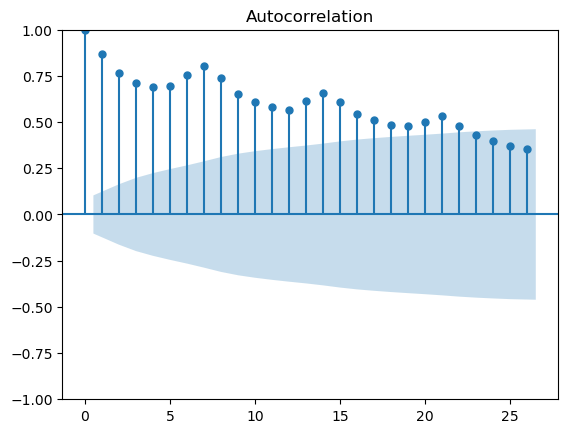

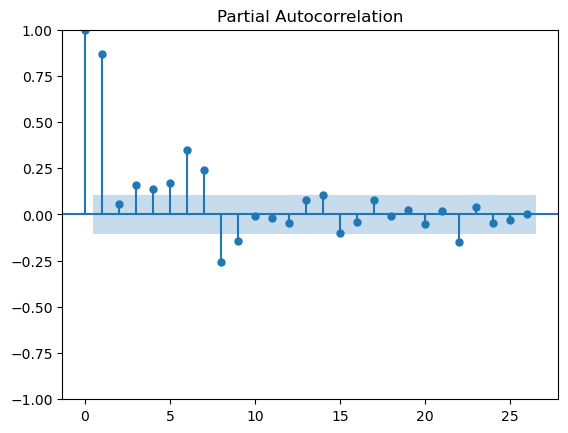

In [383]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()

In [384]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# # Adding exogenous variables (e.g., weather, holidays)
exog_train = data_post_covid[
    ["temp","humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all", "Is_Holiday"]
][:-31]
exog_test = data_post_covid[
    ["temp","humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all", "Is_Holiday"]
][-31:]


# Fit SARIMAX with exogenous variables
sarima_model = SARIMAX(
    train, exog=exog_train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 7)
)
sarima_fit = sarima_model.fit(disp=False)

# Forecast with exogenous variables
sarima_forecast = sarima_fit.forecast(steps=len(test), exog=exog_test)


# --- Model 2: Exponential Smoothing (ETS) ---
ets_model = ExponentialSmoothing(
    train, seasonal="mul", seasonal_periods=7
)  # Weekly seasonality
ets_fit = ets_model.fit()

# Forecast for the test period
ets_forecast = ets_fit.forecast(steps=len(test))

# Evaluate both models
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

ets_mae = mean_absolute_error(test, ets_forecast)
ets_rmse = np.sqrt(mean_squared_error(test, ets_forecast))

# Results
results = pd.DataFrame(
    {
        "Model": ["SARIMA", "ETS"],
        "MAE": [sarima_mae, ets_mae],
        "RMSE": [sarima_rmse, ets_rmse],
    }
)
results

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

,Model,MAE,RMSE
0,SARIMA,5639.008994,7585.857808
1,ETS,3764.788205,5808.401258


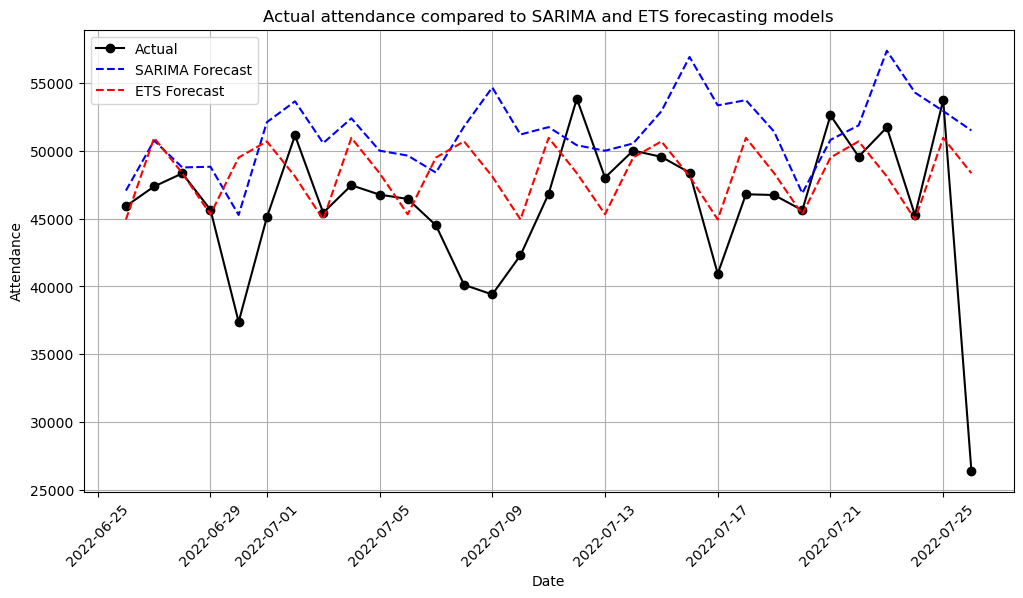

In [385]:
plt.figure(figsize=(12, 6))

# Utiliser les vraies dates pour l'axe des X
plt.plot(test_dates, test, label="Actual", color="black", marker="o")
plt.plot(test_dates, sarima_forecast, label="SARIMA Forecast", color="blue", linestyle="--")
plt.plot(test_dates, ets_forecast, label="ETS Forecast", color="red", linestyle="--")

plt.title("Actual attendance compared to SARIMA and ETS forecasting models")
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Améliorer la lisibilité des dates
plt.show()


In [386]:
print(test.tail(10))  # Vérifier les 10 dernières valeurs d'attendance


1172    40938.0
1173    46808.0
1174    46753.0
1175    45627.0
1176    52637.0
1177    49586.0
1178    51748.0
1179    45261.0
1180    53764.0
1181    26391.0
Name: attendance, dtype: float64


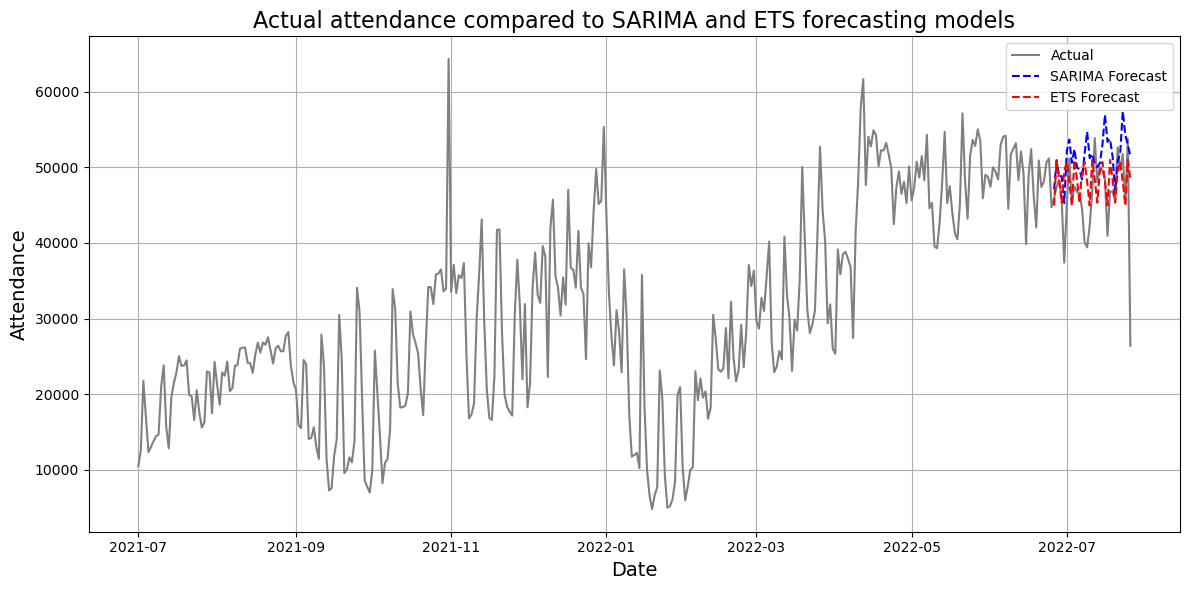

In [392]:
# Plot actual data for the period before the last month as well as the test period
plt.figure(figsize=(12, 6))

# Plot the full range of actual data (train + test)
plt.plot(test_full_context_dates, attendance, label="Actual", color="gray")

# Highlight the forecasted period for SARIMA and ETS
plt.plot(
    test_dates, sarima_forecast, label="SARIMA Forecast", color="blue", linestyle="--"
)
plt.plot(test_dates, ets_forecast, label="ETS Forecast", color="red", linestyle="--")

# Add titles and labels
plt.title("Actual attendance compared to SARIMA and ETS forecasting models", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Attendance", fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##  Predicting August values with our model 

In [317]:
future_attendance_august = pd.read_csv("final_data/future_attendance_august.csv")

future_attendance_august["date"] = pd.to_datetime(future_attendance_august["date"])

future_attendance_august = add_is_holiday(future_attendance_august)

future_exog = future_attendance_august[["temp", "humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all", "Is_Holiday"]]

future_attendance_august.head()

print(future_exog.index.min(), future_exog.index.max())  # Vérifier l’intervalle de dates
print(len(future_exog))  # Vérifier le nombre de jours


0 22
23


In [318]:
# Filtrer future_exog uniquement sur la période souhaitée
start_date = "2022-08-01"
end_date = "2022-08-23"
future_exog = future_exog[(future_attendance_august["date"] >= start_date) & 
                          (future_attendance_august["date"] <= end_date)]

# Vérifier la taille après filtrage
print(len(future_exog))  # Doit être 23


23


In [326]:
# Prédiction SARIMAX avec exogènes
# Créer un nouvel index pour SARIMA sur août 2022
sarima_forecast_august.index = pd.date_range(start="2022-08-01", periods=len(future_exog), freq="D")

# Prédiction ETS (sans exogènes)
ets_forecast_august = ets_fit.forecast(steps=len(future_exog))
# Créer un nouvel index pour SARIMA sur août 2022
ets_forecast_august.index = pd.date_range(start="2022-08-01", periods=len(future_exog), freq="D")



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [327]:
ets_forecast_august

2022-08-01    44942.371446
2022-08-02    50974.460367
2022-08-03    48365.777603
2022-08-04    45327.353737
2022-08-05    49519.983416
2022-08-06    50712.646942
2022-08-07    48122.540471
2022-08-08    44942.371446
2022-08-09    50974.460367
2022-08-10    48365.777603
2022-08-11    45327.353737
2022-08-12    49519.983416
2022-08-13    50712.646942
2022-08-14    48122.540471
2022-08-15    44942.371446
2022-08-16    50974.460367
2022-08-17    48365.777603
2022-08-18    45327.353737
2022-08-19    49519.983416
2022-08-20    50712.646942
2022-08-21    48122.540471
2022-08-22    44942.371446
2022-08-23    50974.460367
Freq: D, dtype: float64

In [328]:
sarima_forecast_august

2022-08-01    48182.848839
2022-08-02    51431.670228
2022-08-03    52981.932225
2022-08-04    49599.790773
2022-08-05    52113.828805
2022-08-06    54223.437373
2022-08-07    54502.126920
2022-08-08    51531.224994
2022-08-09    53098.932263
2022-08-10    53809.880037
2022-08-11    53437.997611
2022-08-12    55154.473821
2022-08-13    56170.433149
2022-08-14    53518.965959
2022-08-15    48939.638522
2022-08-16    50831.535670
2022-08-17    50456.756081
2022-08-18    50352.955679
2022-08-19    50316.643368
2022-08-20    52237.400857
2022-08-21    53819.226165
2022-08-22    50772.885083
2022-08-23    52302.392055
Freq: D, Name: predicted_mean, dtype: float64

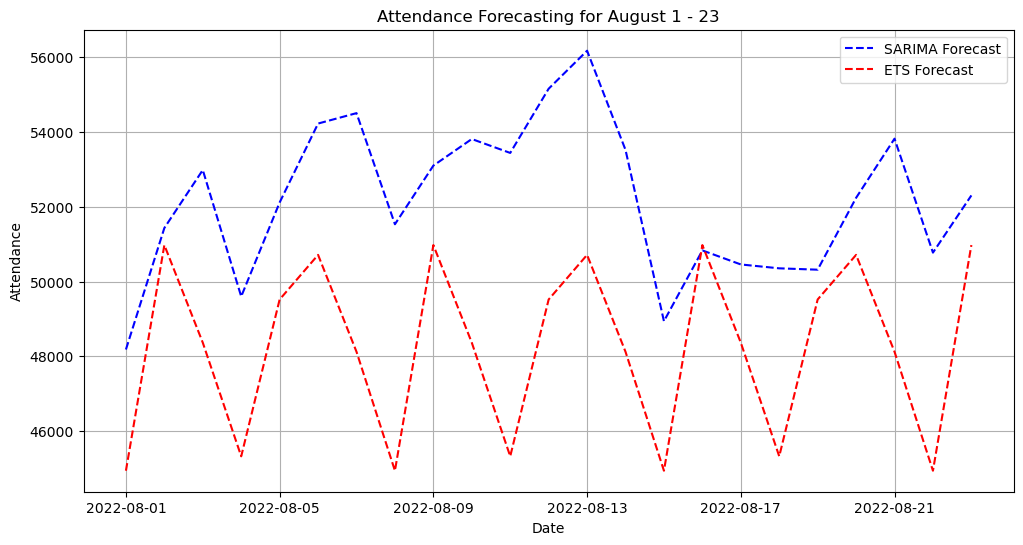

In [301]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual values if available
if "attendance" in future_attendance_august.columns:
    plt.plot(future_attendance_august["date"], future_attendance_august["attendance"], 
             label="Actual Attendance", color="black", marker="o")

# Plot SARIMAX predictions
plt.plot(future_attendance_august["date"], sarima_forecast_august, 
         label="SARIMA Forecast", color="blue", linestyle="--")

# Plot ETS predictions
plt.plot(future_attendance_august["date"], ets_forecast_august, 
         label="ETS Forecast", color="red", linestyle="--")

plt.title("Attendance Forecasting for August 1 - 23")
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.legend()
plt.grid()
plt.show()


In [332]:
# Créer un DataFrame avec les prédictions
predictions_df = pd.DataFrame({
    "date": sarima_forecast_august.index,  # Utiliser l'index déjà corrigé
    "sarima_forecast": sarima_forecast_august.values,
    "ets_forecast": ets_forecast_august.values
})

predictions_df

,date,sarima_forecast,ets_forecast
0,2022-08-01,48182.848839,44942.371446
1,2022-08-02,51431.670228,50974.460367
2,2022-08-03,52981.932225,48365.777603
3,2022-08-04,49599.790773,45327.353737
4,2022-08-05,52113.828805,49519.983416
5,2022-08-06,54223.437373,50712.646942
6,2022-08-07,54502.126920,48122.540471
7,2022-08-08,51531.224994,44942.371446
8,2022-08-09,53098.932263,50974.460367
9,2022-08-10,53809.880037,48365.777603


In [333]:
future_attendance_august = future_attendance_august.merge(predictions_df, on="date", how="left")

future_attendance_august["day_of_week"] = future_attendance_august["date"].dt.day_name()

future_attendance_august


,date,temp,humidity,wind_speed,rain_1h,snow_1h,clouds_all,Is_Holiday,sarima_forecast,ets_forecast,day_of_week
0,2022-08-01,21.955417,76.000000,1.875417,0.31,0.0,1541,1,48182.848839,44942.371446,Monday
1,2022-08-02,24.008333,68.958333,1.662917,0.00,0.0,1293,1,51431.670228,50974.460367,Tuesday
2,2022-08-03,27.089583,60.000000,1.629167,0.00,0.0,310,1,52981.932225,48365.777603,Wednesday
3,2022-08-04,23.155833,71.625000,2.892917,5.18,0.0,1820,1,49599.790773,45327.353737,Thursday
4,2022-08-05,20.261667,72.250000,4.294167,0.00,0.0,899,1,52113.828805,49519.983416,Friday
5,2022-08-06,18.844167,53.708333,4.826250,0.00,0.0,175,1,54223.437373,50712.646942,Saturday
6,2022-08-07,20.575833,51.875000,4.947083,0.00,0.0,388,1,54502.126920,48122.540471,Sunday
7,2022-08-08,22.107083,53.291667,4.722917,0.00,0.0,0,1,51531.224994,44942.371446,Monday
8,2022-08-09,23.745000,55.125000,4.455000,0.00,0.0,0,1,53098.932263,50974.460367,Tuesday
9,2022-08-10,25.480417,48.416667,3.951250,0.00,0.0,76,1,53809.880037,48365.777603,Wednesday


In [334]:
future_attendance_august.to_csv("final_data/predicted_future_attendance_august.csv", index = False)

- visualisation echelle time serie pour l'attendance, 
- x axis pour des valeurs cohérentes
- chai pas? 